In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Lab 3

Today the lab is a bit more sparse on explanation, but I think it would be nice to drill down into gaussian mixture modeling. 

Let's start with the old faithful data you used in your homework:

In [2]:
from urllib2 import urlopen
path = 'faithful.txt'
remote = urlopen('https://raw.githubusercontent.com/aidiary/PRML/master/ch9/faithful.txt')
with open('faithful.txt', 'w') as f:
    f.write(remote.read())

<IPython.core.display.Javascript object>


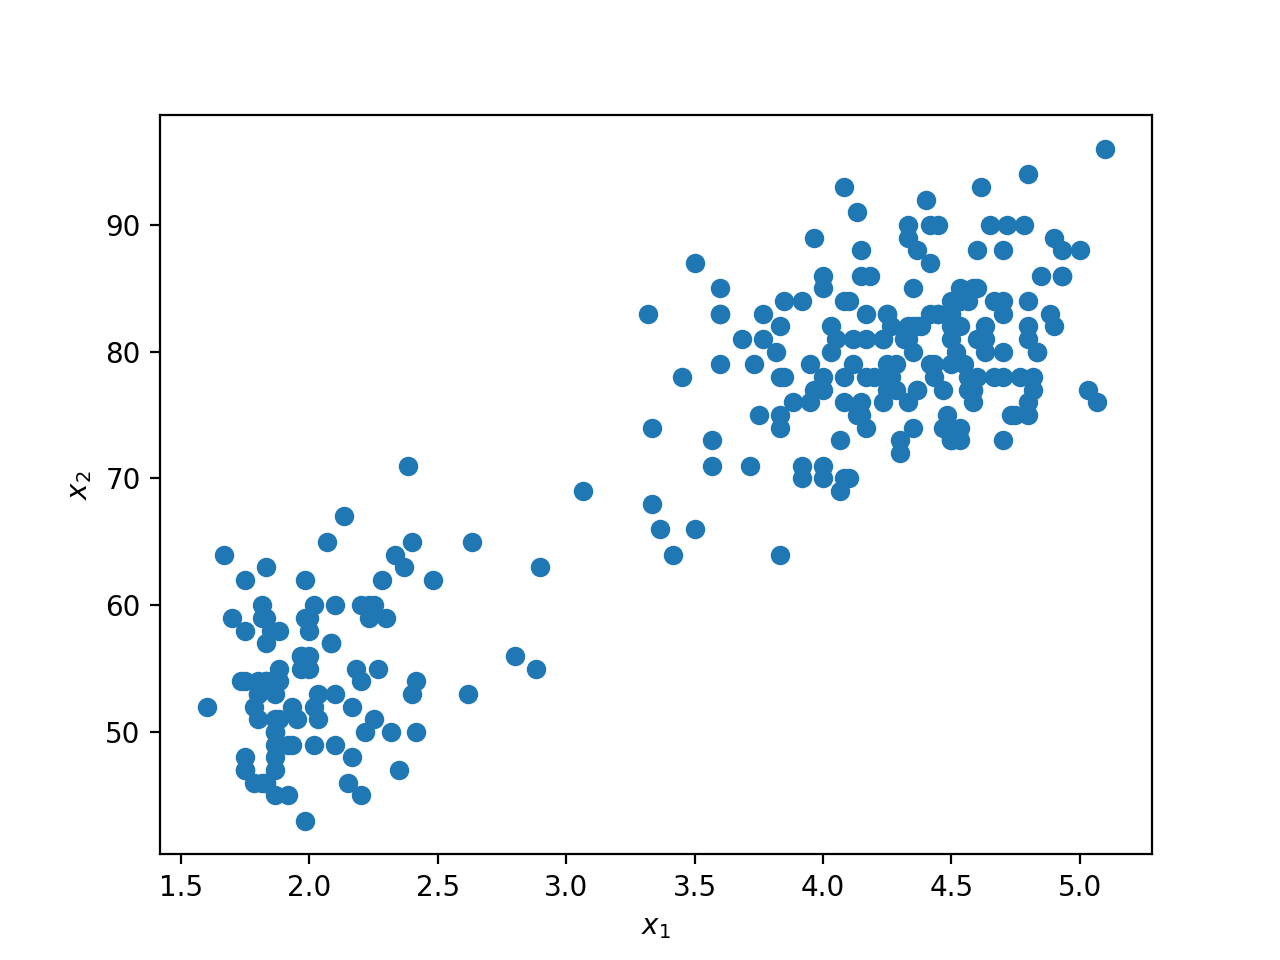

In [3]:
import pandas
df = pandas.read_csv(path, sep=' ', names=['x_1', 'x_2'])

x1 = df.loc[:,'x_1'].as_matrix()
x2 = df.loc[:,'x_2'].as_matrix()


figure()
scatter(x1, x2)
xlabel(r'$x_1$')
ylabel(r'$x_2$')
show()

Let's start with a marginal distribution

<IPython.core.display.Javascript object>


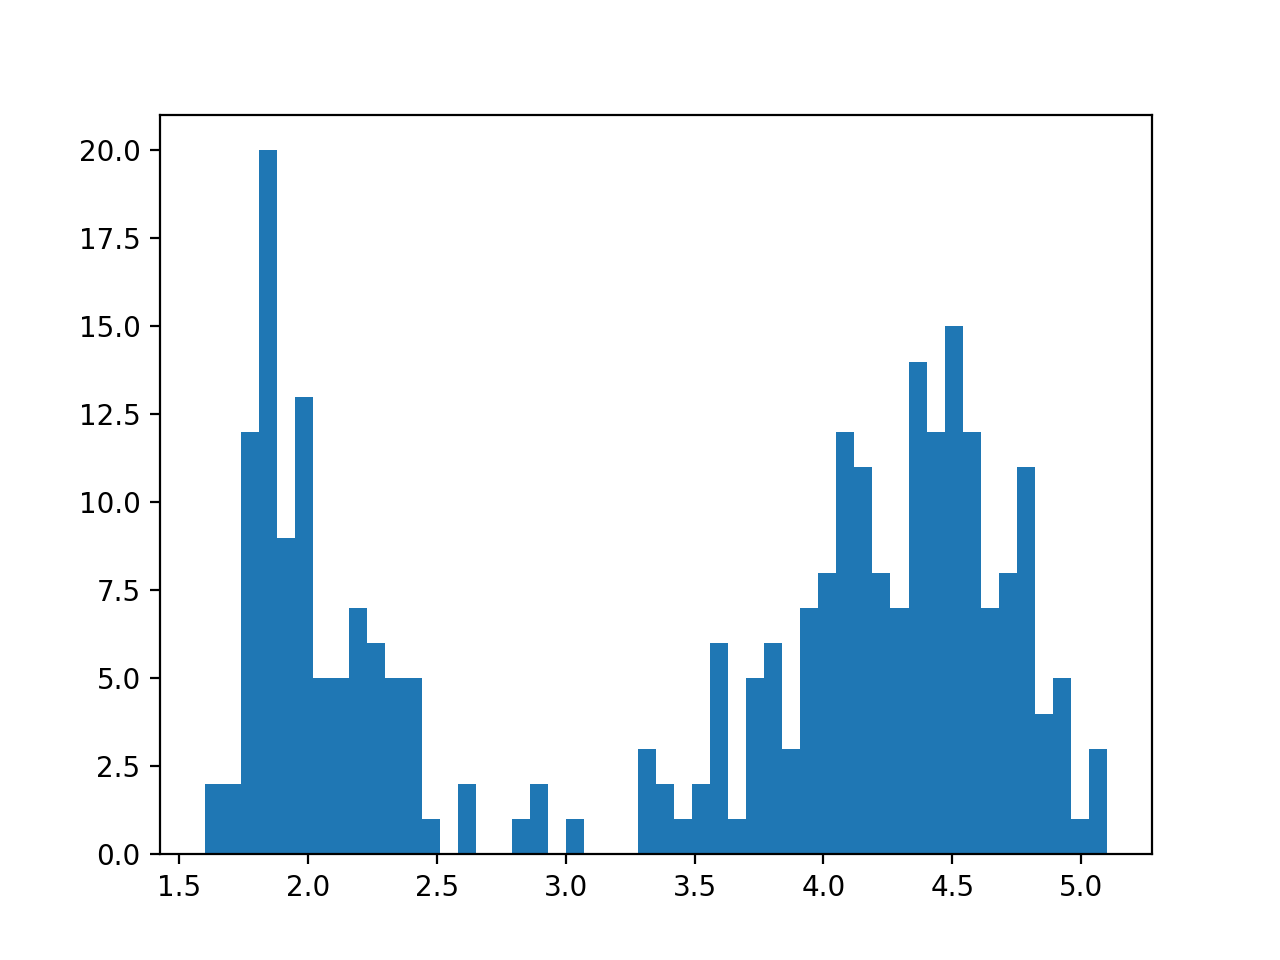

In [4]:
figure()
hist(x1, bins=50)
show()

This look's like maybe it is two Gaussians; let's focus on the one on the right. 

<IPython.core.display.Javascript object>


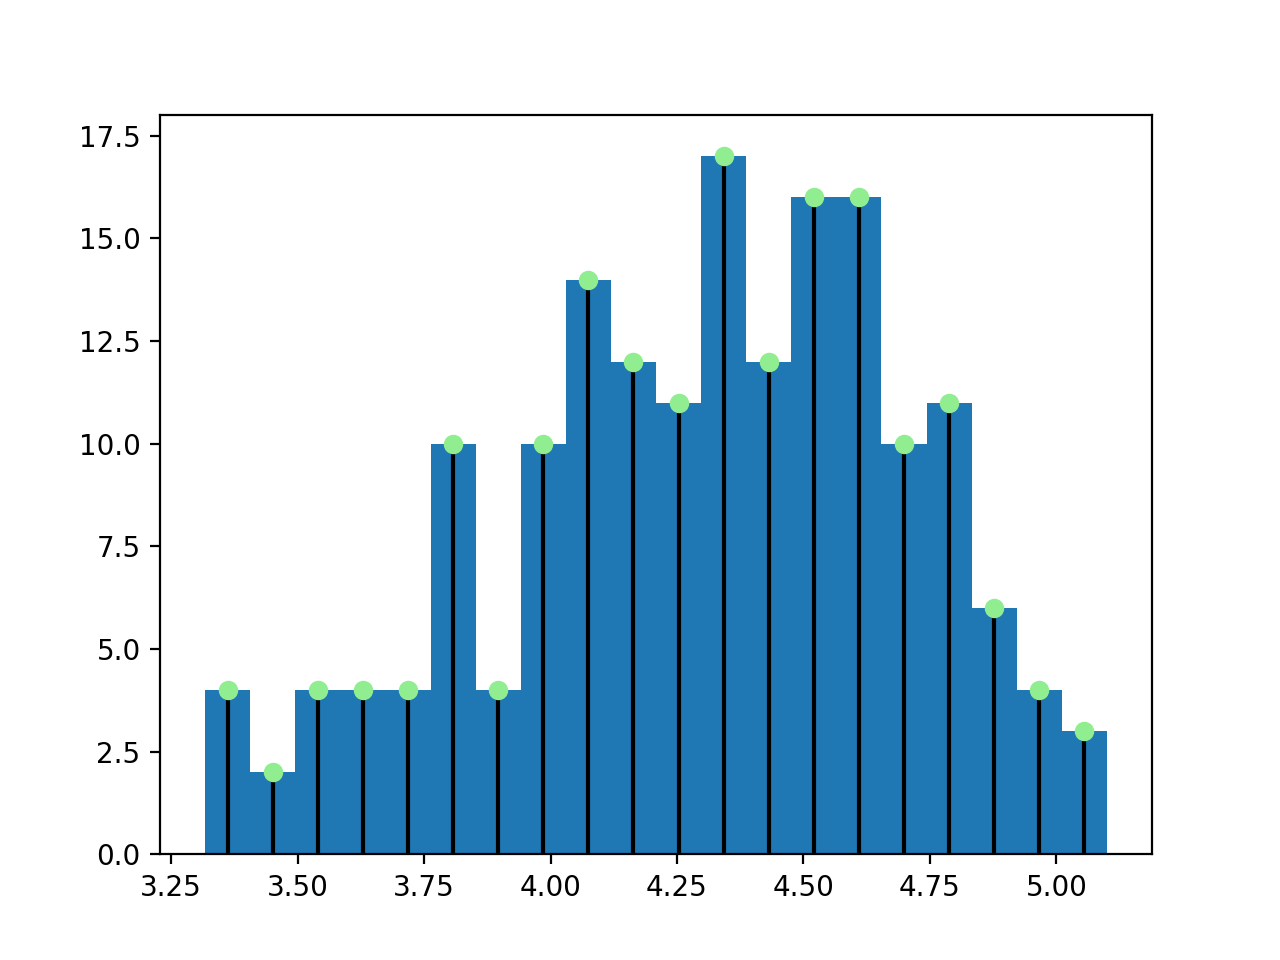

In [5]:
threshold = 3.25
x_r = x1[x1 > threshold]

figure()
hist(x_r, bins=20)
show()

In [6]:
freqs, edges = histogram(x_r, bins=20)
centers = (edges[:-1]+edges[1:])/2.

# This will be drawn on the figure above
vlines(centers, 0, freqs)
scatter(centers, freqs, color='lightgreen', zorder=2)
show()

# Challenge
Find the covariance an mean given `freqs` and `centers` only. 
Note that the input it not _samples_, it is a _sample value_ followed by a sample _wieight_

In [7]:
def weighted_gaussian_fit(x, w):
    n = len(x)
    assert len(w) == n

    W = sum(w)
    mu = sum(w*x)/W
    var = sum(w*x**2)/W - mu**2
    
    return (mu, var)

The next cell lets you visualize the results. 

<IPython.core.display.Javascript object>


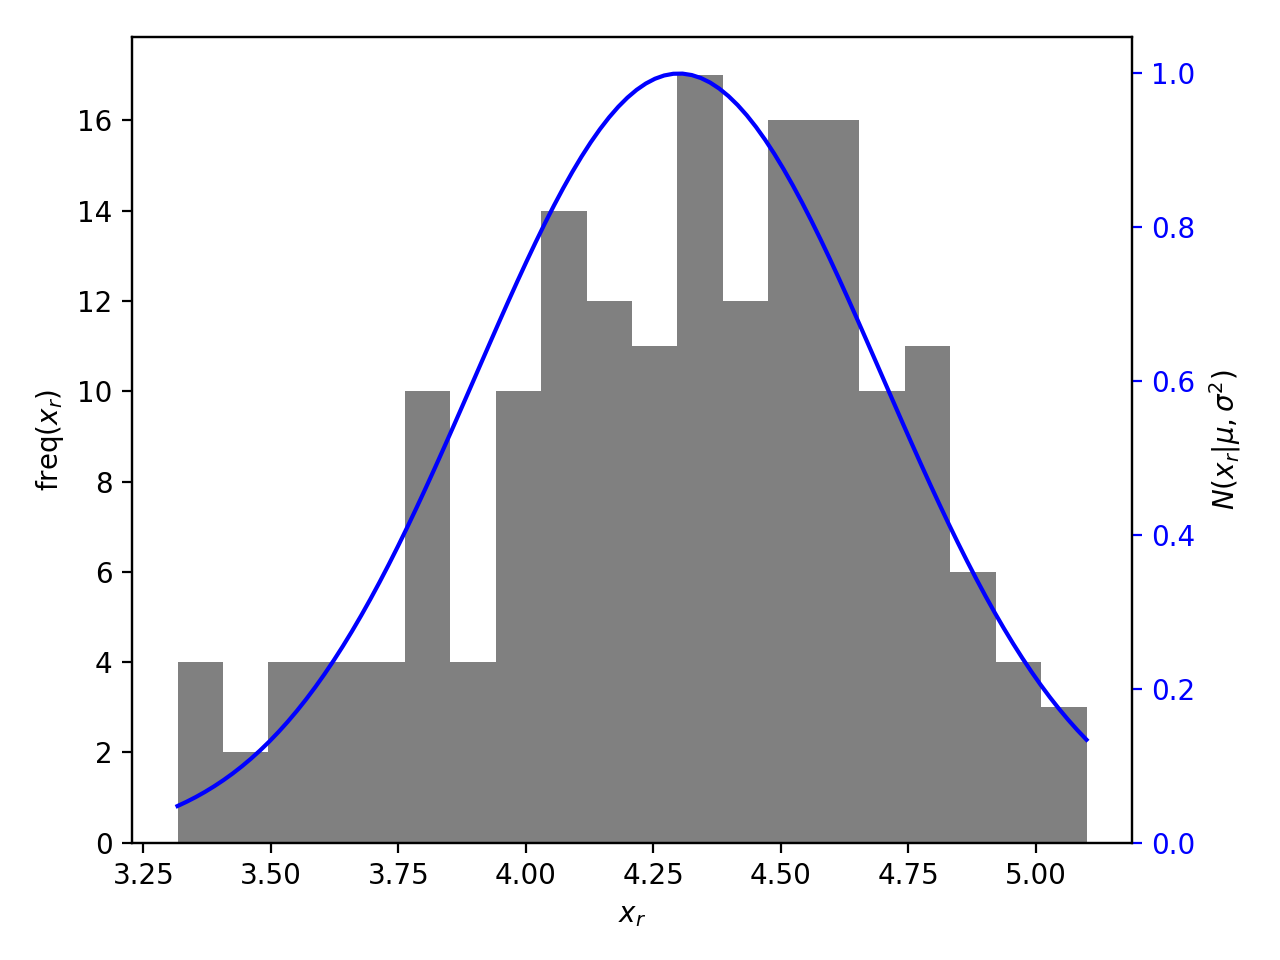

In [8]:
mu, var = weighted_gaussian_fit(centers, freqs)

x_fit = linspace(x_r.min(), x_r.max(), 100)
y_fit = (1./sqrt(2*pi*var))*exp(-((x_fit-mu)**2)/(2*var))

fig = figure()
hist(x_r, bins=20, color='grey', zorder=1)
xlabel(r'$x_r$')
ylabel(r'freq($x_r$)')

twinx()
ylabel('$N(x_r|\mu,\sigma^2)$')
tick_params('y', colors='blue')
plot(x_fit, y_fit, color='blue', zorder=2)
tight_layout()
show()

# Challenge
Now, let's extend that to a multivariate (2D) gaussian

In [9]:
x1_r = x_r
x2_r = x2[x1 > threshold ]

<IPython.core.display.Javascript object>


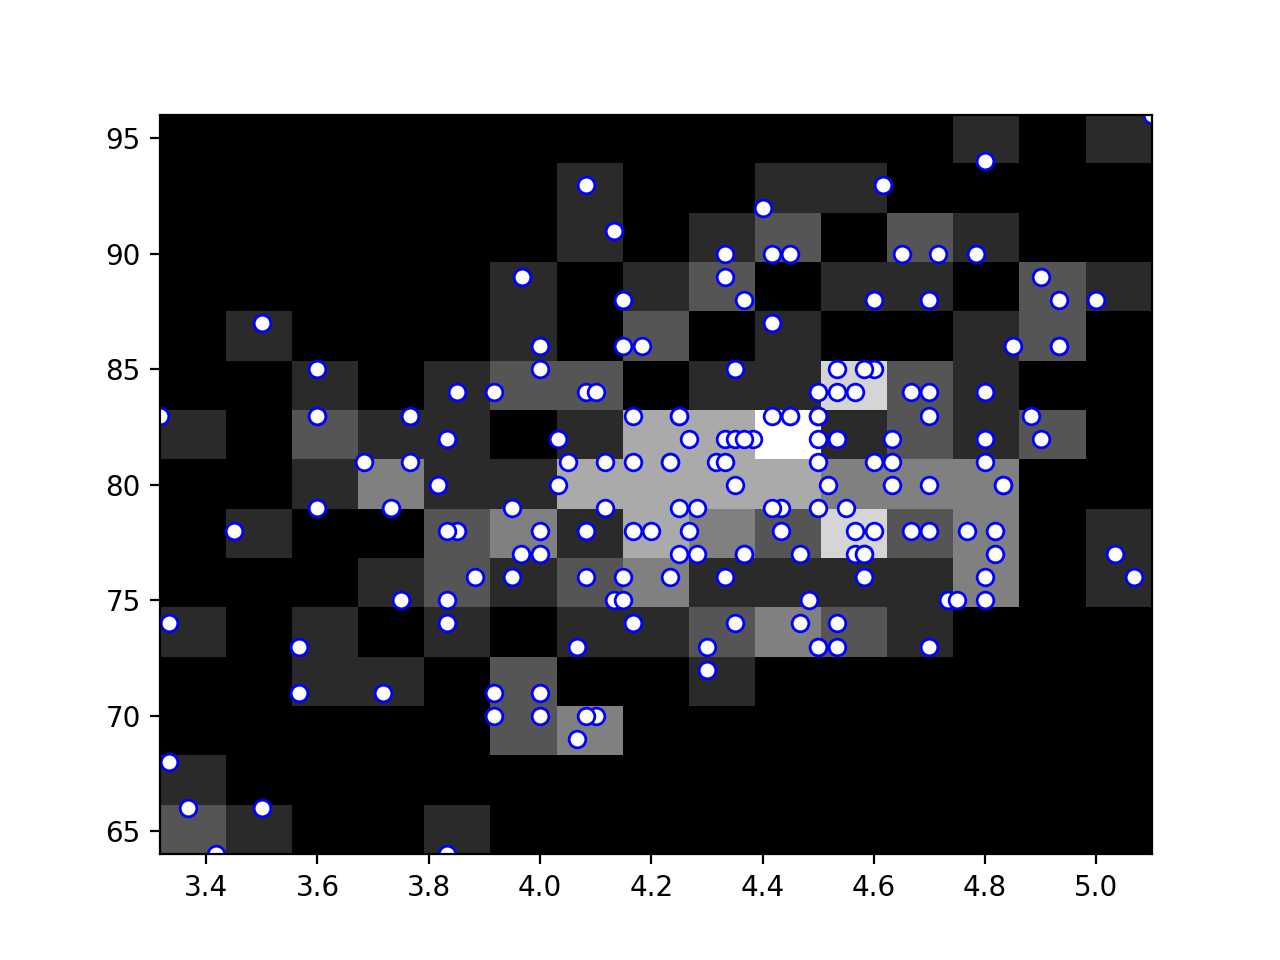

In [10]:
figure()
hist2d(x1_r, x2_r, bins=(15, 15), cmap=cm.gray)
scatter(x1_r, x2_r, edgecolor='blue', facecolor='white')
show()

In [11]:
freqs, x1_edges, x2_edges = histogram2d(x1_r, x2_r, bins=(15, 15))
x1_centers = (x1_edges[:-1] + x1_edges[1:])/2.
x2_centers = (x2_edges[:-1] + x2_edges[1:])/2.

In [12]:
x1_centers, x2_centers= meshgrid((x1_edges[:-1] + x1_edges[1:])/2., 
                                 (x2_edges[:-1] + x2_edges[1:])/2.)
x_centers = column_stack([x1_centers.flat, x2_centers.flat])
freqs = freqs.flatten()

Let's verify that we have coordinate pairs $(x_1, x_2)$ and frequencies aligned properly by visualizing the weighted points as circles of different sizes. 

<IPython.core.display.Javascript object>


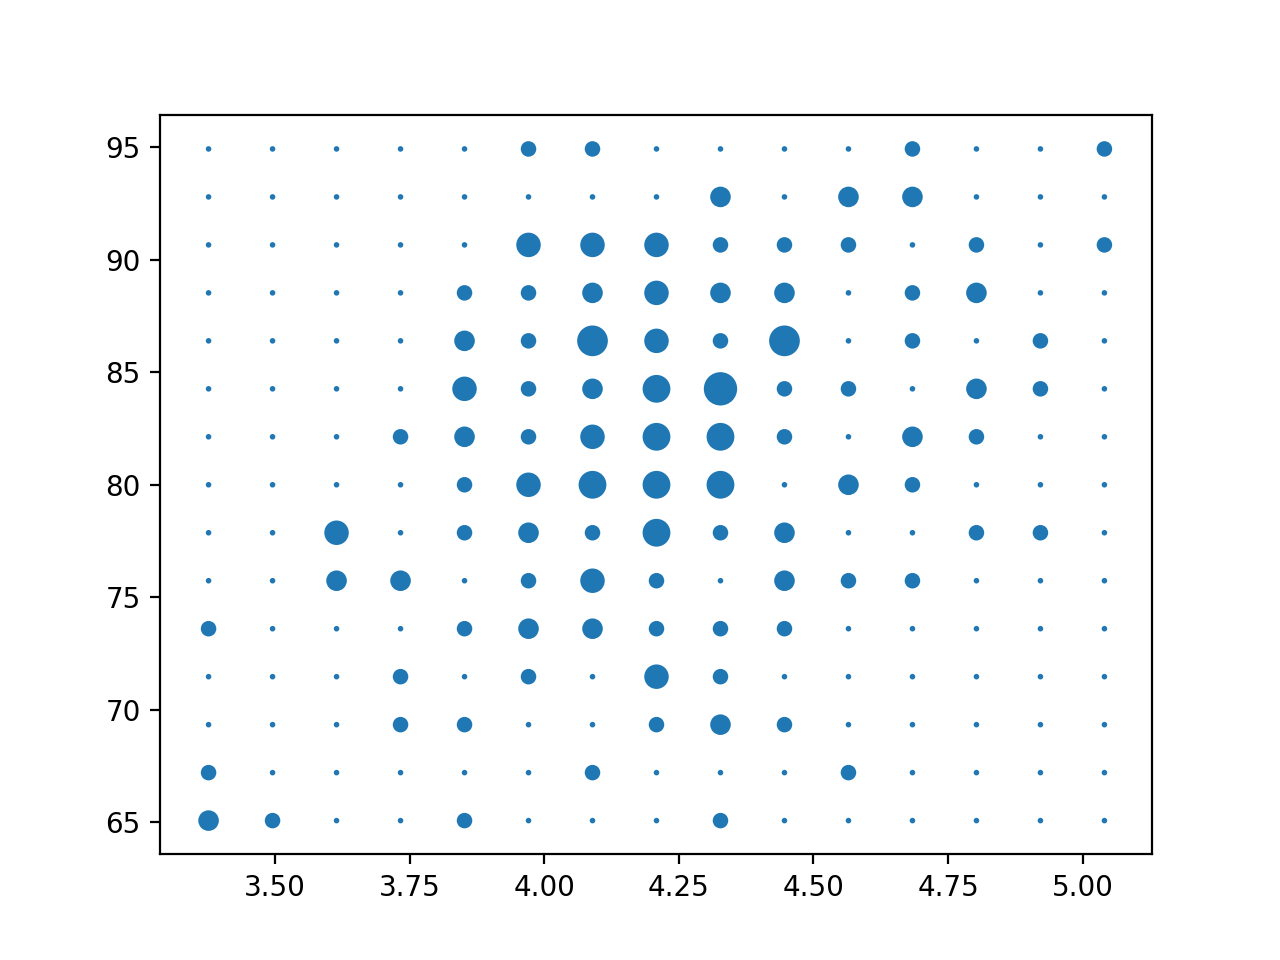

In [13]:
figure()
scatter(x_centers[:,0], x_centers[:,1], s=1+20*freqs)
show()

Now, the challenge is to find the **2D** gaussian function that is most likely. 

In [14]:
def weighted_mv_guassian_fit(x, w):
    n, m = x.shape
    assert w.shape[0] == n
    
    W = sum(w)
    mu = sum(w.T*x.T, 1)/W
    cov = (w.T*x.T).dot(x)/W - outer(mu, mu)    
    
    return (mu, cov)

In [15]:
import scipy.stats

<IPython.core.display.Javascript object>


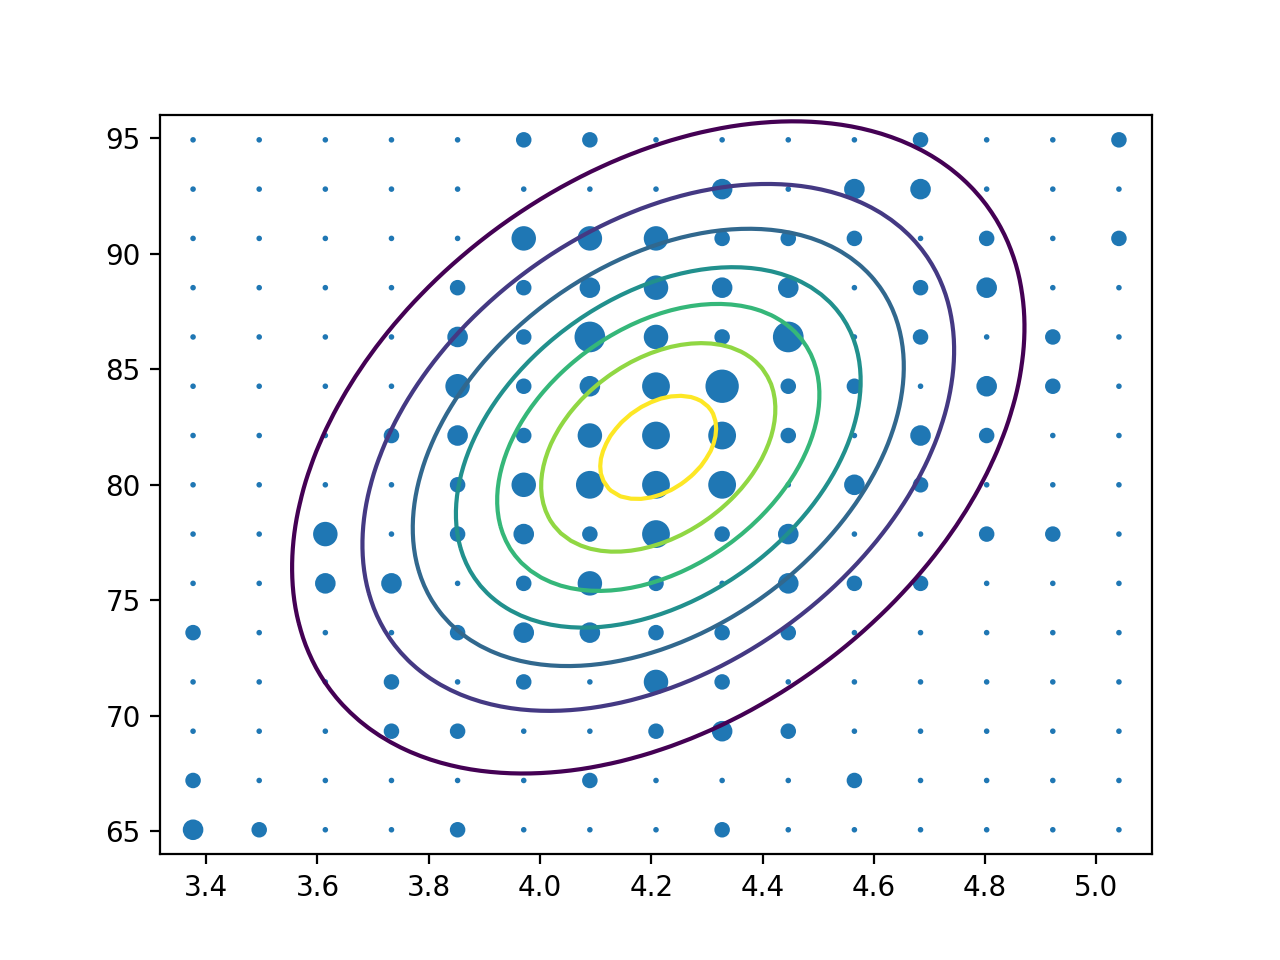

In [16]:
figure()
mu, cov = weighted_mv_guassian_fit(x_centers, freqs)

scatter(x_centers[:,0], x_centers[:,1], s=1+20*freqs)

X, Y = mgrid[x1_r.min():x1_r.max():100j, x2_r.min():x2_r.max():100j]
D = c_[X.flatten(), Y.flatten()]
Z=scipy.stats.multivariate_normal.pdf(D, mu, cov).reshape((100,100))
contour(X, Y, Z)
show()

In [17]:
Z.shape

(100, 100)

# Challenge: Multiple 1D Gaussians
Returning to the original data, we thought that $x_1$  may have been a mixture of two gaussians.

Later, we may discuss Gaussian mixture models in more depth (PRML Ch. 9). 

For now, I will introduce a simple _K means_ algorithm, with pseudocode:

<img src="http://stanford.edu/~cpiech/cs221/img/kmeansMath.png"></img>

This algorithm solves _only_ for the means of a set of Gaussian's, and it assumes that they all have the same variance. 

In [18]:
def kmeans(x, k):
    # This algorithm iteratively reduces the negative log likelihood
    # It stops when two iterations result in the same cluster assignments 
    converged = False
    
    # Select `k` initial 'mus', e.g. using np.random.choice?
    mus = x[random.choice(len(x), k), ...]
    
    while not converged:
        
        #Calculate the cluster assignments
        mahalanobis2 = column_stack([sum(c_[(x-mu)**2],1) for mu in mus])
        clusters = argmin(mahalanobis2, axis=1)
        
        old_mus = mus
        
        #Update mus
        mus = array([mean(x[clusters==j]) for j in range(k)])
        
        converged = all(old_mus == mus)
        
        yield old_mus, clusters

If you keep evaluating the next cell, you will move through the algorithm one iteration at a time. 

<IPython.core.display.Javascript object>


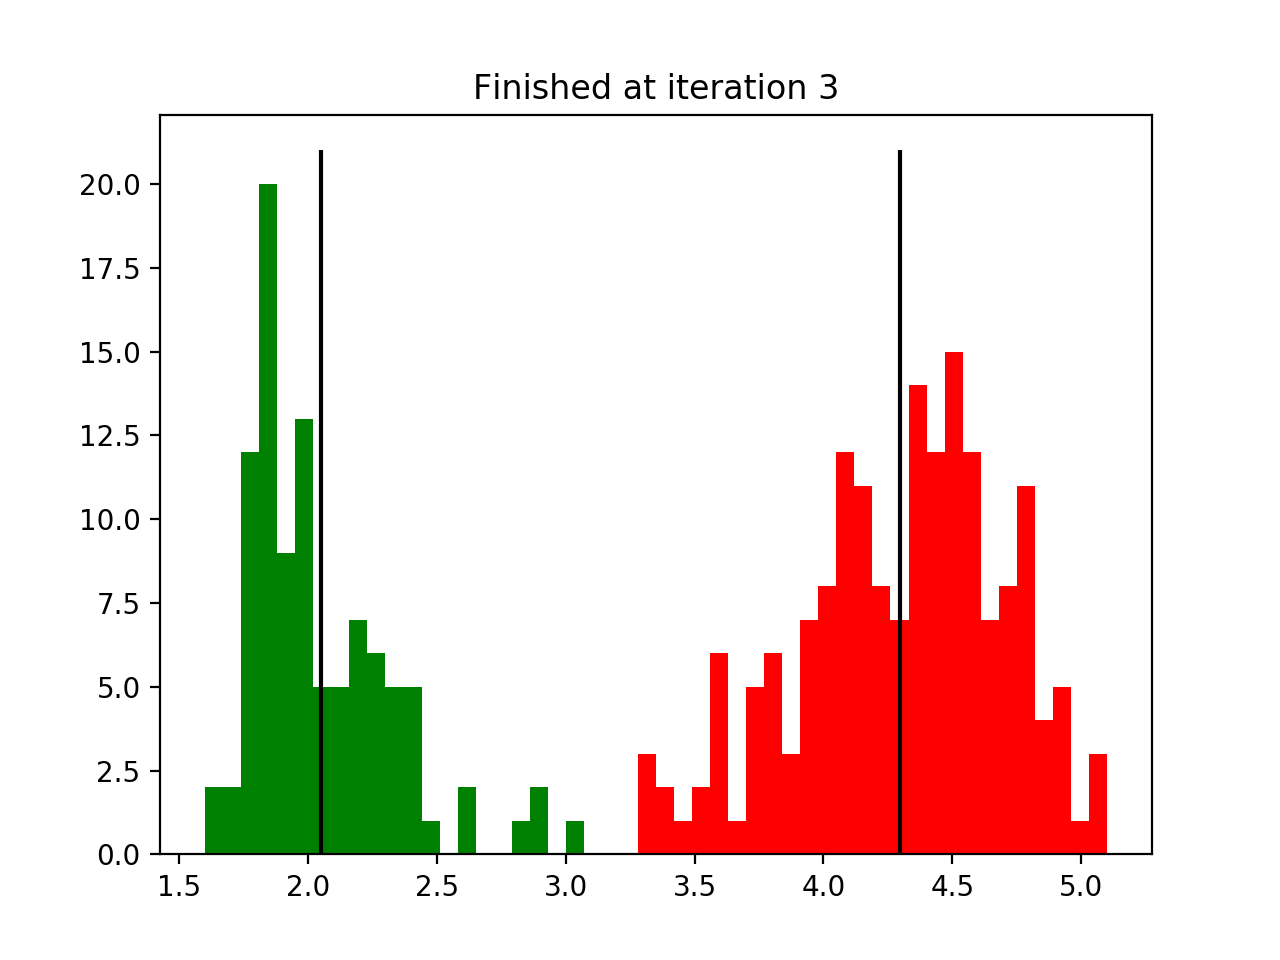

In [19]:
# The plot will look incorrect until you fix the code above
fig = figure()
from time import sleep

for k, (mus, clusters) in enumerate(kmeans(x1, 2)):
    clf()
    x1_range = (x1.min(), x1.max())
    hist(x1[clusters==0], bins=50, range=x1_range, color='red')
    hist(x1[clusters==1], bins=50, range=x1_range, color='green')
    vlines(mus, 0, ylim()[1])
    title('Iteration {}'.format(k))
    fig.canvas.draw()
    sleep(1)
title('Finished at iteration {}'.format(k))

# More of the Same Challenge...
If you implemented the code above _just_ right (or if you edit it a bit), then it will work on multidimensional data as well. 
Give it a try:

In [20]:
process = kmeans(column_stack([x1, x2]), 2)

In [21]:
figure()

for k, (mus, clusters) in enumerate(kmeans(column_stack([x1, x2]), 2)):
    clf()
    scatter(x1[clusters==0], x2[clusters==0], color='red', s=5)
    scatter(x1[clusters==1], x2[clusters==1], color='green', s=5)
    scatter(mus[:,0], mus[:,1], color='blue', zorder=3)
    text(mus[0,0], mus[0,1], '  $\mu_1$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
    text(mus[1,0], mus[1,1], '  $\mu_2$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
    title('Iteration {}'.format(k))
    sleep(1)
                                    

<IPython.core.display.Javascript object>

IndexError: too many indices for array